In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, Dropout, BatchNormalization)

RANDOM_STATE = 42
DATA_DIR = Path(".")
HR_FILE   = DATA_DIR / "heartrate_15min.csv"
DX_FILE   = DATA_DIR / "Diagnoses_20250404.csv"


In [3]:
# ---- load diagnoses -------------------------------------------------
diag = (pd.read_csv(DX_FILE, parse_dates=["DCDate.diagnosis_baseline"])
          .rename(columns={"DCDate.diagnosis_baseline": "BaselineDate"})
          .dropna(subset=["BaselineDate"])
          [["PIDN", "BaselineDate", "Diagnosis_baseline_3groups"]])

# ---- load HR --------------------------------------------------------
hr = pd.read_csv(HR_FILE, parse_dates=["Time"])
hr = hr[hr.PIDN.isin(diag.PIDN)]

hr = hr.merge(diag[["PIDN", "BaselineDate"]], on="PIDN", how="left")
assert hr["BaselineDate"].notna().all()

# ---- helper to make a 1344-long vector ------------------------------
def hr_to_seq(grp, n_days=14):
    """Return a zero-filled 1-D array (1344,) for this participant."""
    bdate = grp["BaselineDate"].iloc[0].date()
    after = grp[grp.Time.dt.date >= bdate]
    start = after.Time.min() if not after.empty else grp.Time.min()
    # full 14-day index at 15-min cadence
    full_index = pd.date_range(start=start.floor("D"),
                               periods=96*n_days, freq="15min")
    seq = (grp.set_index("Time")
          .reindex(full_index)["Value"]
          .ffill(limit=1)        # forward-fill tiny gaps
          .bfill(limit=1)        # backward-fill tiny gaps   ◀︎ new style
          .fillna(grp["Value"].median()))

    # normalise per participant (z-score)
    seq = (seq - seq.mean()) / (seq.std(ddof=0) + 1e-6)
    return seq.to_numpy(dtype=np.float32)

# ---- build the dataset ---------------------------------------------
seqs, labels = [], []
for pid, g in hr.groupby("PIDN"):
    seqs.append(hr_to_seq(g))
    labels.append(diag.loc[diag.PIDN == pid,
                           "Diagnosis_baseline_3groups"].iloc[0])

X_seq = np.stack(seqs)                       # shape (n, 1344)
y_bin = (pd.Series(labels) != "Clinically Normal").astype(int).to_numpy()

print("Sequence shape :", X_seq.shape, "|  positives :", y_bin.sum())


Sequence shape : (192, 1344) |  positives : 70


In [5]:
# ================================================================
# CELL 2 · Train / test split  +  class-weight calculation
# (run after CELL 1 where X_seq  and y_bin are created)
# ================================================================

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ---- 1.  stratified 20 % hold-out ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_bin,
    test_size=0.20,
    stratify=y_bin,
    random_state=42
)

# ---- 2.  add channel dimension for Conv1D  ---------------------------
# shapes:  (n_train, 1344, 1)   and   (n_test, 1344, 1)
X_train = X_train[..., None]
X_test  = X_test [..., None]

# ---- 3.  compute class weights (sklearn ≥ 1.2 needs ndarray) ---------
classes = np.array([0, 1])
cw_vals = compute_class_weight(class_weight="balanced",
                               classes=classes,
                               y=y_train)
class_weights = {0: cw_vals[0], 1: cw_vals[1]}
print("Class weights :", class_weights)


Class weights : {0: np.float64(0.788659793814433), 1: np.float64(1.3660714285714286)}


In [10]:
from tensorflow.keras.regularizers import l2
tf.keras.utils.set_random_seed(42)

model = Sequential([
    Input(shape=(1344,1)),
    Conv1D(32, 7, strides=2, activation="relu",
           kernel_regularizer=l2(1e-4)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation="relu",
           kernel_regularizer=l2(1e-4)),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.15,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3984 - loss: 0.6986 - val_accuracy: 0.3913 - val_loss: 0.7036
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6135 - loss: 0.6964 - val_accuracy: 0.4348 - val_loss: 0.7119
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5992 - loss: 0.6844 - val_accuracy: 0.4348 - val_loss: 0.7143
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7026 - loss: 0.6846 - val_accuracy: 0.4348 - val_loss: 0.7151
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6298 - loss: 0.6938 - val_accuracy: 0.4348 - val_loss: 0.7151
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6135 - loss: 0.6915 - val_accuracy: 0.3913 - val_loss: 0.7129
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5111 - loss: 0.7009 - val_accuracy: 0.3913 - val_loss: 0.7087
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5530 - loss: 0.6939 - val_accuracy: 0.4348 - val_loss:

TEST balanced-accuracy : 0.5
Abnormal recall : 1.0
[[ 0 25]
 [ 0 14]]


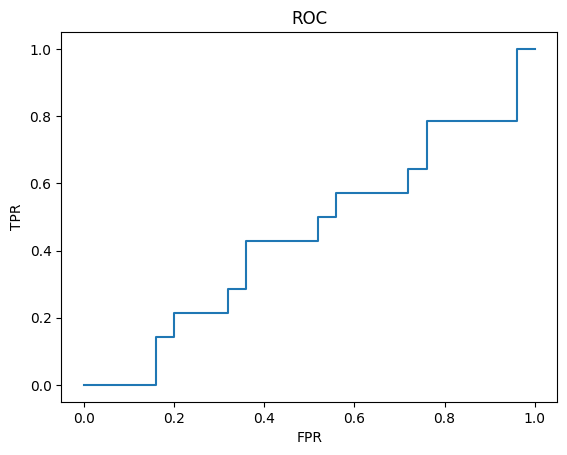

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, recall_score

# probability predictions
probs_seq = model.predict(X_test, verbose=0).ravel()

# default cut 0.5
y_pred = (probs_seq >= 0.5).astype(int)

print("TEST balanced-accuracy :", round(balanced_accuracy_score(y_test, y_pred), 3))
print("Abnormal recall :", round(recall_score(y_test, y_pred), 3))
print(confusion_matrix(y_test, y_pred))

# ---- simple ROC to choose a threshold like before if needed ----------
from sklearn.metrics import roc_curve
fpr, tpr, thr = roc_curve(y_test, probs_seq)
plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC");
